# Fig03_PR-analysis
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.12.2019
    Date last modified: 19.12.2019

    ##############################################################
    Purpos:

    1) Reads in hourly precipitation from one case MCS

    2) plot a representative slice of hourly precip
    
    3) Read in statistical evaluation of simulate precipitation and plot
       the results.





In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
# import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import matplotlib.path as mplPath
from pylab import *
from scipy.optimize import curve_fit
import scipy
import math
import SkewT
from scipy.interpolate import interp1d
# from astropy.io import ascii

In [2]:
################################################################################
################################################################################
#                            Settings

rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgrDX=[12000,12000,4000,2000,1000,500,250]
sSimDir='/glade/p/mmm/c3we/Idealized_MCSs/data/WRF/'

rgsSimulation=['03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5']

iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/Fig03_PR/'

rgiDomSize=[51,51,155,311,623,1247,2495]
iOutInt=12 # slizes per hour
ihours=7 # runtime in hours
iSkipH=3 # hours that should be excluded from the simulation
iRadPmax=60000. # m
iRadVol=100000. # m for the volume calculation

### Process example hourly precipitation accumulation

In [3]:
grMaxPRall={}
iTT=20
for si in range(len(rgsSimulation)):
    grSimPR={}
    print '    Process '+rgsSimulation[si]
    for dx in range(len(rgrGridSpacing)):
        print '        Process '+rgrGridSpacing[dx]
        iDgc=int(12000./float(rgrDX[dx]))
        iRadGC=int(iRadPmax/float(rgrDX[dx])/2.)+iDgc
        iVolRad=int(iRadVol/float(rgrDX[dx]))
        # read in the precipiation variables
        rgrPRact=np.zeros((ihours*iOutInt,rgiDomSize[dx], rgiDomSize[dx])); rgrPRact[:]=np.nan
        for hh in range(ihours):
            for tt in range(iOutInt):
                if rgrGridSpacing[dx] != '250':
                    sFileAct=sSimDir+rgsSimulation[si]+'/'+rgrGridSpacing[dx]+'/wrfout_d01_0001-01-01_'+str("%02d" % hh)+':'+str("%02d" % (tt*5))+':*'
                else:
                    sFileAct=sSimDir+rgsSimulation[si]+'/'+rgrGridSpacing[dx]+'/Combined/wrfout_d01_2000-01-01_'+str("%02d" % hh)+':'+str("%02d" % (tt*5))+':*'
                try:
                    sFileAct=glob.glob(sFileAct)[0]
                    ncid=Dataset(sFileAct, mode='r') # open the netcdf file
                except:
                    stop()
                rgrRAINNC=np.squeeze(ncid.variables['RAINNC'][:])
                rgrGRAUPELNC=np.squeeze(ncid.variables['GRAUPELNC'][:])
                rgrHAILNC=np.squeeze(ncid.variables['HAILNC'][:])
                rgrSNOWNC=np.squeeze(ncid.variables['SNOWNC'][:])
                rgrTotalPR=rgrRAINNC+rgrGRAUPELNC+rgrHAILNC+rgrSNOWNC
                if rgrGridSpacing[dx] == '12000':
                    rgrRAINC=np.squeeze(ncid.variables['RAINC'][:])
                    rgrRAINSH=np.squeeze(ncid.variables['RAINSH'][:])
                    rgrTotalPR=rgrRAINC+rgrRAINSH+rgrTotalPR
                try:
                    rgrPRact[hh*iOutInt+tt,:,:]=rgrTotalPR
                except:
                    stop()

        # calculate hourly rainfall accumulations
        rgrPRact=rgrPRact[iSkipH*iOutInt:,:,:]
        rgrHourly=(rgrPRact[iOutInt:,:,:]-rgrPRact[:-iOutInt,:,:])[iTT,:,:]
        grMaxPRall[str(rgrGridSpacing[dx])]=rgrHourly


    Process 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
        Process 12000
        Process 12000nc
        Process 4000
        Process 2000
        Process 1000
        Process 500
        Process 250


### Load MCS Characteristics
This data is preprocessed by:

~/papers/Idealized-MCSs/programs/MCS-Tracking/MCS-Tracking.py

In [7]:
rgsSimulations=['19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5'] #,

#                 '64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
#                 '41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5']


iSkipTi=3*12 # hours times intervals per hour that should be excluded from the simulation
sGrid='12km'  # can be 'native' for native grid or '12km' for 12 km model grid
sDataDir='/glade/scratch/prein/Papers/Idealized_MCSs/data/MCS-Characteristics/'+sGrid+'/'
iSmoothKM=36000 # smoothing filter lenth in m
iPR_threshold=5  # precipitation threshold in mm/h
# ###############################################
#                 # Data Processing

rgrTrackDist=np.zeros((ihours*12-iSkipTi+1,len(rgsSimulations),len(rgrGridSpacing))); rgrTrackDist[:]=np.nan
rgrMCSspeed=np.zeros((len(rgsSimulations),len(rgrGridSpacing),5)); rgrMCSspeed[:]=np.nan
rgrPRvol=np.zeros((len(rgsSimulations),len(rgrGridSpacing))); rgrPRvol[:]=np.nan
rgrPRmax=np.zeros((len(rgsSimulations),len(rgrGridSpacing))); rgrPRmax[:]=np.nan
rgrPRmean=np.zeros((len(rgsSimulations),len(rgrGridSpacing))); rgrPRmean[:]=np.nan
rgrMCSsice=np.zeros((len(rgsSimulations),len(rgrGridSpacing))); rgrMCSsice[:]=np.nan
rgrCorr_RMSE_Overlap=np.zeros((len(rgsSimulations),len(rgrGridSpacing),3)); rgrCorr_RMSE_Overlap[:]=np.nan
for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname=sDataDir+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_Smooth-'+str(iSmoothKM)+'_PR-TH-'+str(iPR_threshold)+'.p'
            grDATA[rgrGridSpacing[dx]]=pickle.load( open( fname, "rb" ) )['0']
        except:
            continue
    grRef=grDATA['250']
    for dx in range(len(rgrGridSpacing)-1):
        try:
            grMod=grDATA[rgrGridSpacing[dx]]
        except:
            continue

        # Calculate the track distance
        if sGrid == 'native':
            rgrRefTrack=grRef['rgrMassCent']*250./1000.
            rgrModTrack=grMod['rgrMassCent']*rgrDX[dx]/1000.
        else:
            rgrRefTrack=grRef['rgrMassCent']*rgrDX[dx]/1000.
            rgrModTrack=grMod['rgrMassCent']*rgrDX[dx]/1000.
        if np.isnan(np.nanmean(rgrRefTrack)) != 1:
            rgrTrackDistAct=np.zeros((len(rgrModTrack))); rgrTrackDistAct[:]=np.nan
            for tt in range(len(rgrModTrack)):
                if np.isnan(rgrModTrack[tt,0]) != 1:
                    rgrTrackDistAct[tt]=np.nanmin(((rgrModTrack[tt,0]-rgrRefTrack[:,0])**2+(rgrModTrack[tt,1]-rgrRefTrack[:,1])**2)**0.5)
    #         stop()
    #         rgrTrackDistAct=np.array([np.nanmin(((rgrModTrack[tt,0]-rgrRefTrack[:,0])**2+(rgrModTrack[tt,1]-rgrRefTrack[:,1])**2)**0.5) for tt in range(len(rgrModTrack))])
        try:
            rgrTrackDist[:len(rgrTrackDistAct),si,dx]=rgrTrackDistAct
        except:
            rgrTrackDist[:,si,dx]=rgrTrackDistAct[:rgrTrackDist.shape[0]]

        # Calculate the object speed
        rgrRefTrack=grRef['rgrObjSpeed']
        rgrModTrack=grMod['rgrObjSpeed']
        if len(rgrRefTrack) != len(rgrModTrack):
            Smaller=np.min([len(rgrRefTrack),len(rgrModTrack)])
            rgrRefTrack=rgrRefTrack[:Smaller]
            rgrModTrack=rgrModTrack[:Smaller]
        # rgrMCSspeed[si,dx,:]=((np.nanpercentile(rgrModTrack, (0,25,50,75,100))-np.nanpercentile(rgrRefTrack, (0,25,50,75,100)))/np.nanpercentile(rgrRefTrack, (0,25,50,75,100)))*100
        rgrMCSspeed[si,dx,:]=np.nanpercentile((rgrModTrack-rgrRefTrack)/rgrRefTrack, (0,25,50,75,100))*100

        # Calculate PR volume
        rgrRefVol=grRef['rgrPR_Vol']
        rgrModVol=grMod['rgrPR_Vol']
        if len(rgrRefVol) != len(rgrModVol):
            Smaller=np.min([len(rgrRefVol),len(rgrModVol)])
            rgrRefVol=rgrRefVol[:Smaller]
            rgrModVol=rgrModVol[:Smaller]
        rgrPRvol[si,dx]=np.nanmedian((rgrModVol-rgrRefVol)/rgrRefVol)*100.

        # Calculate PR-Max
        rgrRefVol=grRef['rgrPR_Max']
        rgrModVol=grMod['rgrPR_Max']
        if len(rgrRefVol) != len(rgrModVol):
            Smaller=np.min([len(rgrRefVol),len(rgrModVol)])
            rgrRefVol=rgrRefVol[:Smaller]
            rgrModVol=rgrModVol[:Smaller]
        rgrPRmax[si,dx]=np.nanmedian((rgrModVol-rgrRefVol)/rgrRefVol)*100.

        # Calculate PR-Mean
        rgrRefVol=grRef['rgrPR_Mean']
        rgrModVol=grMod['rgrPR_Mean']
        if len(rgrRefVol) != len(rgrModVol):
            Smaller=np.min([len(rgrRefVol),len(rgrModVol)])
            rgrRefVol=rgrRefVol[:Smaller]
            rgrModVol=rgrModVol[:Smaller]
        rgrPRmean[si,dx]=np.nanmedian((rgrModVol-rgrRefVol)/rgrRefVol)*100.

        # Calculate MCS size
        rgrRefVol=grRef['rgrSize']
        rgrModVol=grMod['rgrSize']
        if len(rgrRefVol) != len(rgrModVol):
            Smaller=np.min([len(rgrRefVol),len(rgrModVol)])
            rgrRefVol=rgrRefVol[:Smaller]
            rgrModVol=rgrModVol[:Smaller]
        rgrMCSsice[si,dx]=np.nanmedian((rgrModVol-rgrRefVol)/rgrRefVol)*100.
        
        # Calculate Spatial Similarity
        rgrRefPRfp=grRef['rgrPRfootprint']
        rgrModPRfp=grMod['rgrPRfootprint']
        RefObj=(rgrRefPRfp > 0).astype('int')
        ModObj=(rgrModPRfp > 0).astype('int')
        if (ModObj.max() == 0) | (RefObj.max() == 0):
            continue
        OBJtt1=RefObj
        OBJtt2=ModObj
        PRtt1=rgrRefPRfp
        PRtt2=rgrModPRfp
        SOUTH=np.min([np.where(np.max(OBJtt1, axis=1) == 1)[0][0], np.where(np.max(OBJtt2, axis=1) == 1)[0][0]])-6
        NORTH=np.max([np.where(np.max(OBJtt1, axis=1) == 1)[0][-1], np.where(np.max(OBJtt2, axis=1) == 1)[0][-1]])+6
        WEST=np.min([np.where(np.max(OBJtt1, axis=0) == 1)[0][0], np.where(np.max(OBJtt2, axis=0) == 1)[0][0]])-6
        EAST=np.max([np.where(np.max(OBJtt1, axis=0) == 1)[0][-1], np.where(np.max(OBJtt2, axis=0) == 1)[0][-1]])+6
        if np.min([SOUTH,NORTH,WEST,EAST]) < 0:
            if SOUTH < 0:
                SOUTH=0
            if NORTH < 0:
                NORTH=0
            if WEST < 0:
                WEST=0
            if EAST < 0:
                EAST=0
        OBJtt1=OBJtt1[SOUTH:NORTH,WEST:EAST]
        OBJtt2=OBJtt2[SOUTH:NORTH,WEST:EAST]
        PRtt1=PRtt1[SOUTH:NORTH,WEST:EAST]
        PRtt2=PRtt2[SOUTH:NORTH,WEST:EAST]
        # cut tt1 object sharply
        SOUTHs=np.where(np.max(OBJtt1, axis=1) == 1)[0][0]-1
        NORTHs=np.where(np.max(OBJtt1, axis=1) == 1)[0][-1]+1
        WESTs=np.where(np.max(OBJtt1, axis=0) == 1)[0][0]-1
        EASTs=np.where(np.max(OBJtt1, axis=0) == 1)[0][-1]+1
        if np.min([SOUTH,NORTH,WEST,EAST]) < 0:
            continue
        OBJtt1s=OBJtt1[SOUTHs:NORTHs,WESTs:EASTs]
        PRtt1s=PRtt1[SOUTHs:NORTHs,WESTs:EASTs]
        RMSEmatrix=np.zeros((OBJtt2.shape[0]-OBJtt1s.shape[0],OBJtt2.shape[1]-OBJtt1s.shape[1])); RMSEmatrix[:]=np.nan
        MaxOverlap=np.copy(RMSEmatrix)
        MaxCorrel=np.copy(RMSEmatrix)
        for la in range(RMSEmatrix.shape[0]):
            for lo in range(RMSEmatrix.shape[1]):
                RMSEmatrix[la,lo]=np.sqrt(np.mean((OBJtt2[la:la+OBJtt1s.shape[0],lo:lo+OBJtt1s.shape[1]]-OBJtt1s)**2))
                MaxOverlap[la,lo]=np.sum((OBJtt2[la:la+OBJtt1s.shape[0],lo:lo+OBJtt1s.shape[1]] == 1) & (OBJtt1s == 1))
                MaxCorrel[la,lo]=np.corrcoef(PRtt2[la:la+OBJtt1s.shape[0],lo:lo+OBJtt1s.shape[1]].flatten(),PRtt1s.flatten())[0, 1]
        
        rgrCorr_RMSE_Overlap[si,dx,:]=[np.max(MaxCorrel),np.min(RMSEmatrix),np.max(MaxOverlap)]

    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5


/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in divide
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in divide
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in divide
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in divide


### Load stratiform and convectiv precipitation

In [5]:
PRcharacteristic=['Convective','Stratiform']
rgsStats=['Mean PR Diff.','Area Diff.','PR Volume Diff.', 'Mean PR Diff.','Area Diff.','PR Volume Diff.']
iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/Convective-VS-stratiform-PR-volume/'

rgiDomSize=[51,51,155,311,623,1247,2495]
ihours=7 # runtime in hours
iSkipTi=1*12 # hours times intervals per hour that should be excluded from the simulation

rgrPR_CS_Vol=np.zeros((2,len(rgsSimulations),len(rgrGridSpacing),5)); rgrPR_CS_Vol[:]=np.nan
rgrPR_CS_Mean=np.copy(rgrPR_CS_Vol)
CS_Size=np.copy(rgrPR_CS_Vol)

for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname='/glade/scratch/prein/Papers/Idealized_MCSs/data/Conv-vs-Strat_PR/'+sGrid+'/'+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_Smooth-36000_'+sGrid+'-grid_DBZ-2km.pkl'
            grDATA[rgrGridSpacing[dx]]=pickle.load( open( fname, "rb" ) )['0']
        except:
            continue
    grRef=grDATA['250']
    for dx in range(len(rgrGridSpacing)-1):
        try:
            grMod=grDATA[rgrGridSpacing[dx]]
        except:
            continue

        # calculate mean PR diff.
        rgrRefMeanPR_Conv=grRef['rgrPR_Conv_Mean'][24:]
        rgrModMeanPR_Conv=grMod['rgrPR_Conv_Mean'][24:]
        if len(rgrModMeanPR_Conv) < len(rgrRefMeanPR_Conv):
            rgrRefMeanPR_Conv=rgrRefMeanPR_Conv[:len(rgrModMeanPR_Conv)]
        if len(rgrRefMeanPR_Conv) < len(rgrModMeanPR_Conv):
            rgrModMeanPR_Conv=rgrModMeanPR_Conv[:len(rgrRefMeanPR_Conv)]
        rgrPR_CS_Mean[0,si,dx,:]=np.nanpercentile((rgrModMeanPR_Conv-rgrRefMeanPR_Conv)/rgrRefMeanPR_Conv, (0,25,50,75,100))*100
        # rgrPR_CS_Mean[0,si,dx,:]=((np.nanpercentile(rgrModMeanPR_Conv, (0,25,50,75,100))-np.nanpercentile(rgrRefMeanPR_Conv, (0,25,50,75,100)))/np.nanpercentile(rgrRefMeanPR_Conv, (0,25,50,75,100)))*100 
        rgrRefMeanPR_Strat=grRef['rgrPR_Strat_Mean'][24:]
        rgrModMeanPR_Strat=grMod['rgrPR_Strat_Mean'][24:]
        if len(rgrModMeanPR_Strat) < len(rgrRefMeanPR_Strat):
            rgrRefMeanPR_Strat=rgrRefMeanPR_Strat[:len(rgrModMeanPR_Strat)] 
        if len(rgrRefMeanPR_Strat) < len(rgrModMeanPR_Strat):
            rgrModMeanPR_Strat=rgrModMeanPR_Strat[:len(rgrRefMeanPR_Strat)]     
        # rgrPR_CS_Mean[1,si,dx,:]=((np.nanpercentile(rgrModMeanPR_Strat, (0,25,50,75,100))-np.nanpercentile(rgrRefMeanPR_Strat, (0,25,50,75,100)))/np.nanpercentile(rgrRefMeanPR_Strat, (0,25,50,75,100)))*100     
        rgrPR_CS_Mean[1,si,dx,:]=np.nanpercentile((rgrModMeanPR_Strat-rgrRefMeanPR_Strat)/rgrRefMeanPR_Strat, (0,25,50,75,100))*100
        MinLen=np.min([len(grRef['rgrPR_Strat_Mean']),len(grMod['rgrPR_Strat_Mean'])])

        # calculate PR vol difference.
        rgrRefVolPR_Conv=grRef['rgrPR_Conv_Vol'][24:MinLen]
        rgrModVolPR_Conv=grMod['rgrPR_Conv_Vol'][24:MinLen]
        NAN=((rgrRefVolPR_Conv == 0) | (rgrModVolPR_Conv == 0))
        rgrRefVolPR_Conv[NAN]=np.nan; rgrModVolPR_Conv[NAN]=np.nan
        # rgrPR_CS_Vol[0,si,dx,:]=((np.nanpercentile(rgrModVolPR_Conv, (0,25,50,75,100))-np.nanpercentile(rgrRefVolPR_Conv, (0,25,50,75,100)))/np.nanpercentile(rgrRefVolPR_Conv, (0,25,50,75,100)))*100
        rgrPR_CS_Vol[0,si,dx,:]=np.nanpercentile((rgrModVolPR_Conv-rgrRefVolPR_Conv)/rgrRefVolPR_Conv, (0,25,50,75,100))*100
        rgrRefVolPR_Strat=grRef['rgrPR_Strat_Vol'][24:MinLen]
        rgrModVolPR_Strat=grMod['rgrPR_Strat_Vol'][24:MinLen]
        NAN=((rgrRefVolPR_Strat == 0) | (rgrModVolPR_Strat == 0))
        rgrRefVolPR_Strat[NAN]=np.nan; rgrModVolPR_Strat[NAN]=np.nan
        # rgrPR_CS_Vol[1,si,dx,:]=((np.nanpercentile(rgrModVolPR_Strat, (0,25,50,75,100))-np.nanpercentile(rgrRefVolPR_Strat, (0,25,50,75,100)))/np.nanpercentile(rgrRefVolPR_Strat, (0,25,50,75,100)))*100
        rgrPR_CS_Vol[1,si,dx,:]=np.nanpercentile((rgrModVolPR_Strat-rgrRefVolPR_Strat)/rgrRefVolPR_Strat, (0,25,50,75,100))*100
        
        # calculate size diff.
        rgrRefSize_Conv=grRef['Conv_Size'][24:MinLen]
        rgrModSize_Conv=grMod['Conv_Size'][24:MinLen]
        NAN=((rgrRefSize_Conv == 0) | (rgrModSize_Conv == 0))
        rgrRefSize_Conv[NAN]=np.nan; rgrModSize_Conv[NAN]=np.nan
        # CS_Size[0,si,dx,:]=((np.nanpercentile(rgrModSize_Conv, (0,25,50,75,100))-np.nanpercentile(rgrRefSize_Conv, (0,25,50,75,100)))/np.nanpercentile(rgrRefSize_Conv, (0,25,50,75,100)))*100
        CS_Size[0,si,dx,:]=np.nanpercentile((rgrModSize_Conv-rgrRefSize_Conv)/rgrRefSize_Conv, (0,25,50,75,100))*100
        rgrRefSize_Strat=grRef['Strat_Size'][24:MinLen]
        rgrModSize_Strat=grMod['Strat_Size'][24:MinLen]
        NAN=((rgrRefSize_Strat == 0) | (rgrModSize_Strat == 0))
        rgrRefSize_Strat[NAN]=np.nan; rgrModSize_Strat[NAN]=np.nan
        CS_Size[1,si,dx,:]=np.nanpercentile((rgrModSize_Strat-rgrRefSize_Strat)/rgrRefSize_Strat, (0,25,50,75,100))*100
        # CS_Size[1,si,dx,:]=((np.nanpercentile(rgrModSize_Strat, (0,25,50,75,100))-np.nanpercentile(rgrRefSize_Strat, (0,25,50,75,100)))/np.nanpercentile(rgrRefSize_Strat, (0,25,50,75,100)))*100


    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5


## Ploting

        Plot map to: /glade/u/home/prein/papers/Idealized-MCSs/plots/Convective-VS-stratiform-PR-volume/Fig03_Pr-comparison_CTR.pdf


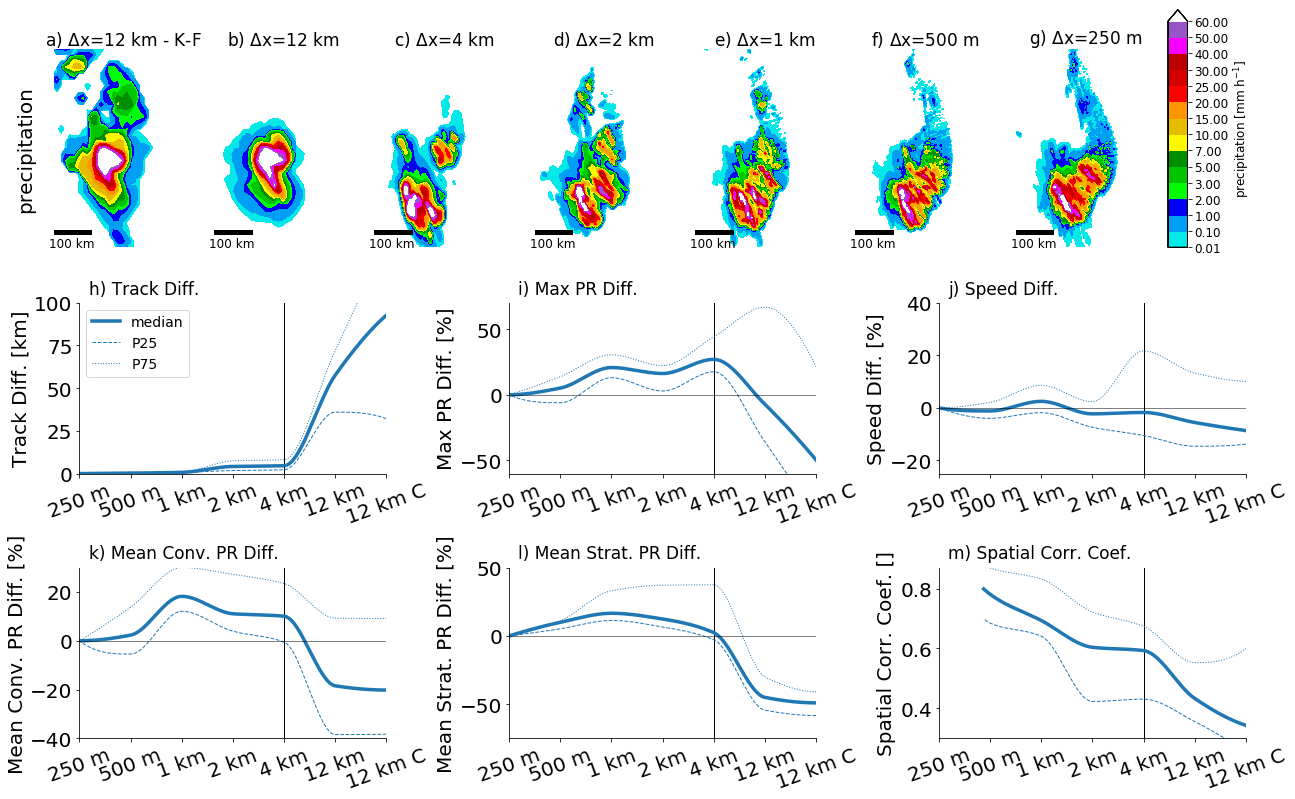

In [8]:
# set the font size
plt.rcParams.update({'font.size': 12})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(18,11))
plt.rcParams.update({'font.size': 20})
gs1 = gridspec.GridSpec(1,len(rgrGridSpacing))
gs1.update(left=0.05, right=0.9,
           bottom=0.7, top=0.95,
           wspace=0.15, hspace=0.3)

nws_precip_colors = [
    "#04e9e7",  # 0.01 - 0.10 inches
    "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
    "#f800fd",  # 6.00 - 8.00 inches
    "#9854c6"  # 8.00 - 10.00 inches
       # 10.00+
]
levels = [0.01, 0.1, 1, 2, 3, 5, 7,10, 15, 20, 25, 30,
          40, 50, 60]

rgsGrids=['precipitation','vertical windspeed','cloud top\ntemperature']

for dx in range(len(rgrGridSpacing)):
    rgrPRact=grMaxPRall[str(rgrGridSpacing[dx])]
    rgrAxis=np.linspace(0,rgrPRact.shape[0]*float(rgrDX[dx]),rgrPRact.shape[0])/1000.
    ax = plt.subplot(gs1[0,dx])
    ax.axis('off')
    if dx == 0:
        ax.text(-0.2,0.5, 'precipitation', ha='center', va='center', fontsize=20,transform = ax.transAxes, rotation=90) #, fontweight='bold')
    cs = ax.contourf(rgrAxis, rgrAxis,rgrPRact, levels=levels, colors=nws_precip_colors, extend='max',zorder = 1)
    cs.cmap.set_over("#fdfdfd")
    sCBlabel='precipitation [mm h$^{-1}$]'
    TicksCB=levels

    # plot a line for scale reference
    ax.plot([260,360],[30,30],lw=5, c='k')
    ax.text(310,20,'100 km', ha='center', va='top', fontsize=12)

    if rgrGridSpacing[dx] == '250':
        ax.text(0.5,1, rgsLableABC[dx]+') $\Delta$x='+str(250)+' m', ha='center', va='bottom', 
                fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    elif rgrGridSpacing[dx] == '500':
        ax.text(0.5,1, rgsLableABC[dx]+') $\Delta$x='+str(500)+' m', ha='center', va='bottom', 
                fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    else:
        if rgrGridSpacing[dx] == '12000':
            # use of cumulus scheme
            ax.text(0.5,1,rgsLableABC[dx]+') $\Delta$x='+str(int(float(rgrDX[dx])/1000.))+' km - K-F', ha='center', va='bottom', 
                    fontsize=17,transform = ax.transAxes) #, fontweight='bold')
        else:
            ax.text(0.5,1,rgsLableABC[dx]+') $\Delta$x='+str(int(float(rgrDX[dx])/1000.))+' km', ha='center', va='bottom', 
                    fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    plt.grid()
    ax.set_ylim([0,390])
    ax.set_xlim([260,650])
    ax.axis('off')        

    # add colorbar
    pos1 = ax.get_position()
    CbarAx = axes([0.91,0.7, 0.015, 0.3])
    cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max', ticks=TicksCB) #, ticks=np.linspace(0,120,13))
    cb.set_label(label=sCBlabel,size=12)
    cb.ax.tick_params(labelsize=12)

# ------------------------------------
# Start ensemble evaluation
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.07, right=0.97,
           bottom=0.08, top=0.63,
           wspace=0.40, hspace=0.55)

rgsColors=['#1f78b4','#e31a1c']
rgsPeriods=['CUR','FUT']
rgsStats=['Track Diff.','Max PR Diff.','Speed Diff.','Mean Conv. PR Diff.','Mean Strat. PR Diff.', 'Spatial Corr. Coef.']
XX=[0,1,2,0,1,2]
YY=[0,0,0,1,1,1]
for st in range(len(rgsStats)):
    ax = plt.subplot(gs1[YY[st],XX[st]])
    if rgsStats[st] == 'Track Diff.':
        DATA=np.nanmedian(rgrTrackDist, axis=0)
        Yrange=[0,100]
    if rgsStats[st] == 'Speed Diff.':
        DATA=rgrMCSspeed[:,:,2]
        Yrange=[-25,40]
    if rgsStats[st] == 'Size Diff.':
        DATA=rgrMCSsice
        Yrange=[-100,30]
    if rgsStats[st] == 'PR. Volume Diff.':
        DATA=rgrPRvol
        Yrange=[-100,50]
    if rgsStats[st] == 'Mean PR Diff.':
        DATA=rgrPRmean
        Yrange=[-50,60]
    if rgsStats[st] == 'Max PR Diff.':
        DATA=rgrPRmax
        Yrange=[-60,70]
    if rgsStats[st] == 'Mean Conv. PR Diff.':
        DATA=rgrPR_CS_Mean[0,:,:,2]
        Yrange=[-40,30]
    if rgsStats[st] == 'Mean Strat. PR Diff.':
        DATA=rgrPR_CS_Mean[1,:,:,2]
        Yrange=[-75,50]
    if rgsStats[st] == 'Spatial Corr. Coef.':
        DATA=rgrCorr_RMSE_Overlap[:,:,0]; DATA[:,-1]=1
        Yrange=[0.3,0.87]
        
        
    
#     if rgsStats[st] != 'Mean Conv. PR Diff.':
    rgrPolygons=np.zeros((len(rgrGridSpacing),5)); rgrPolygons[:]=np.nan
    for dx in range(len(rgrGridSpacing)):
#         iCTR=np.array([('_CTRL_' in rgsSimulations[ii]) & ('TH5PGW' not in rgsSimulations[ii])  for ii in range(len(rgsSimulations))])
#         iPGW=np.array(['_PGW_' in rgsSimulations[ii]  for ii in range(len(rgsSimulations))])
#         iCTRPGW=np.array(['TH5PGW' in rgsSimulations[ii]  for ii in range(len(rgsSimulations))])
#         rgsSimCTR=np.array(rgsSimulations)[iCTR == True]; rgsSimPGW=np.array(rgsSimulations)[iPGW == True]; rgsSimCTRPGW=np.array(rgsSimulations)[iCTRPGW == True]

        rgrDataAct=DATA[:,dx]
        rgrPercentiles=np.nanpercentile(rgrDataAct[:10], (10,25,50,75,90))
        rgrPolygons[dx,:]=rgrPercentiles
        rgrPolygons[np.isnan(rgrPolygons)]=0

        if dx == (len(rgrGridSpacing)-1):
            # plot horizontal reference lines
            ax.axhline(y=rgrPercentiles[2], ls='-', c='k', zorder=-1, alpha=0.6, lw=0.2)
#     else:
#         rgrPolygons=np.nanmedian(DATA[:,:,:], axis=0)

    Xaxis=np.round(np.arange(0,len(rgrGridSpacing)+0.025,0.025),3)
    RealPoints = [np.where(Xaxis == ii)[0][0] for ii in range(len(rgrDX))]
    try:
        DataInt=np.copy(Xaxis); DataInt[:]=np.nan; DataInt[RealPoints[:]]=rgrPolygons[:,2]
    except:
        stop()
    s = pd.Series(DataInt)
    MEDIAN=s.interpolate(method='pchip')
    if rgsStats[st] == 'Spatial Corr. Coef.':
        MEDIAN[-75:]=np.nan
    ax.plot(Xaxis[::-1], MEDIAN, c=rgsColors[0], lw=3.5, alpha=1, label='median')
    
    DataInt=np.copy(Xaxis); DataInt[:]=np.nan; DataInt[RealPoints[:]]=rgrPolygons[:,1]
    s = pd.Series(DataInt)
    P25=s.interpolate(method='pchip')
    if rgsStats[st] == 'Spatial Corr. Coef.':
        P25[-75:]=np.nan
    ax.plot(Xaxis[::-1], P25, c=rgsColors[0], lw=1, alpha=1, ls='--', label='P25')
    
    DataInt=np.copy(Xaxis); DataInt[:]=np.nan; DataInt[RealPoints[:]]=rgrPolygons[:,3]
    s = pd.Series(DataInt)
    P75=s.interpolate(method='pchip')
    if rgsStats[st] == 'Spatial Corr. Coef.':
        P75[-75:]=np.nan
    ax.plot(Xaxis[::-1], P75, c=rgsColors[0], lw=1, alpha=1, ls=':', label='P75')
    
    xx = (np.array([0.5,1.5, 2.5, 3.5,4.5,5.5,6.5])+0.5)[::-1]
    labels = np.array([ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m'])
    plt.xticks(xx, labels, rotation=20)
    if rgsStats[st] == 'Track Diff.':
        ax.set_ylabel(rgsStats[st]+' [km]')
    elif rgsStats[st] == 'Spatial Corr. Coef.':
        ax.set_ylabel(rgsStats[st]+' []')
    else:
        ax.set_ylabel(rgsStats[st]+' [%]')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(1, 7)
    plt.axhline(y=0, c='k', lw=0.5)
    plt.ylim(Yrange[0],Yrange[1])
    ax.axvline(x=5, ls='-', c='k', zorder=-1, alpha=1, lw=1)

    ax.text(0.03,1.03, rgsLableABC[st+7]+') '+rgsStats[st], ha='left',va='bottom', \
            transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=17)
    if st == 0:
        plt.legend(loc="upper left",
                   ncol=1, prop={'size':14})

# Plot the figure
sPlotFile=sPlotDir
sPlotName= 'Fig03_Pr-comparison_CTR.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print '        Plot map to: '+sPlotFile+sPlotName
fig.savefig(sPlotFile+sPlotName)